In [1]:
import os
import sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import tensorflow as tf
tf.executing_eagerly()
tf.get_logger().setLevel('ERROR')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

from tqdm import tqdm

from stog.utils.params import Params
from stog.data.dataset_builder import dataset_from_params, iterator_from_params
from stog.data.vocabulary import Vocabulary
from stog.training.trainer import Trainer
from stog.data.dataset import Batch
from model.text_to_amr import TextToAMR

from tensorflow.keras.layers import Embedding, Input, Dense, Flatten, LSTM, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import MeanSquaredError

[2020-04-02 16:18:47,597 INFO] Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .


In [4]:
params = Params.from_file("../model/model_params.yaml")

/home/adylanrff/Documents/Kuliah/TA/amr_parser/stog/utils/params.py:104: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  dict_merge.dict_merge(params_dict, yaml.load(f))


In [5]:
data_params = params['data']
dataset = dataset_from_params(data_params)

[2020-04-02 16:18:47,697 ERROR] Model name 'data/bert-base-cased/bert-base-cased-vocab.txt' was not found in model name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese). We assumed 'data/bert-base-cased/bert-base-cased-vocab.txt' was a path or url but couldn't find any file associated to this path or url.
0it [00:00, ?it/s][2020-04-02 16:18:47,699 INFO] Reading instances from lines in file at: ../data/raw/amr.txt.features
[2020-04-02 16:18:47,758 INFO] POS tag coverage: 0.3087 (184/596)
40it [00:00, 673.01it/s]
[2020-04-02 16:18:47,760 ERROR] Model name 'data/bert-base-cased/bert-base-cased-vocab.txt' was not found in model name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese). We assumed 'data/bert-base-cased/bert-base-cased-vocab.txt' was a path or url but couldn'

Building train datasets ...
False
Building dev datasets ...
False
Building test datasets ...
False


In [6]:
train_data = dataset['train']
dev_data = dataset.get('dev')
test_data = dataset.get('test')

In [7]:
vocab_params = params.get('vocab', {})
vocab = Vocabulary.from_instances(instances=train_data, **vocab_params)
vocab.save_to_files("../data/processed/serialization")

dataset = Batch(train_data)
dataset.index_instances(vocab)
dataset.index_instances(vocab)
print(dataset)


for key in dataset.as_tensor_dict():
    print(key)
    content = dataset.as_tensor_dict()[key]
    if isinstance(content, dict):
        for inner_key in content:
            print("  ", inner_key)

train_iterator, dev_iterater, test_iterater = iterator_from_params(vocab, data_params['iterator'])

train_dataset = Batch(train_data)
train_dataset.index_instances(vocab)

test_dataset = Batch(test_data)
test_dataset.index_instances(vocab)

train_dataset = train_dataset.as_tensor_dict()
test_dataset = test_dataset.as_tensor_dict()

[2020-04-02 16:18:47,892 INFO] Fitting token dictionary from dataset.
100%|██████████| 40/40 [00:00<00:00, 3329.67it/s]
[2020-04-02 16:18:47,910 WARNING] vocabulary serialization directory ../data/processed/serialization is not empty


src_tokens
   encoder_tokens
   encoder_characters
src_must_copy_tags
tgt_tokens
   decoder_tokens
   decoder_characters
src_pos_tags
tgt_pos_tags
tgt_copy_indices
tgt_copy_mask
tgt_copy_map
src_copy_indices
src_copy_map
head_tags
head_indices


In [8]:
def create_model_input(encoder_input, decoder_input, generator_input, parser_input):
    token_encoder_input = encoder_input.get('token')
    pos_encoder_input = encoder_input.get('pos_tag')
    mask_encoder_input = encoder_input.get('mask')
    token_decoder_input = decoder_input.get('token')
    pos_decoder_input = decoder_input.get('pos_tag')

    copy_attention_map_input = generator_input.get('copy_attention_maps')
    coref_attention_map_input = generator_input.get('coref_attention_maps')
    vocab_target_input  = generator_input.get('vocab_targets')
    coref_target_input  = generator_input.get('coref_targets')
    copy_target_input  = generator_input.get('copy_targets')

    edge_heads_input = parser_input.get('edge_heads')
    edge_labels_input = parser_input.get('edge_labels')
    parser_mask_input = parser_input.get('mask')
    coref_input = parser_input.get('corefs')


    # token_encoder_input, 
    # pos_encoder_input, 
    # token_decoder_input, 
    # pos_decoder_input, 
    # copy_attention_maps_input, 
    # coref_attention_maps_input,
    # mask_input,
    # edge_heads_input,
    # edge_labels_input,
    # corefs_input,

    model_input = [
        token_encoder_input, 
        pos_encoder_input, 
        token_decoder_input, 
        pos_decoder_input, 
        copy_attention_map_input, 
        coref_attention_map_input,
        parser_mask_input, 
        edge_heads_input,
        edge_labels_input,
        coref_input,
        vocab_target_input,
        coref_target_input,
        copy_target_input,
        mask_encoder_input
    ]
    
    return model_input


In [9]:
print(vocab)

Vocabulary with namespaces:
 	Non Padded Namespaces: {'must_copy_tags', 'coref_tags'}
 	Namespace: encoder_token_ids, Size: 334 
 	Namespace: encoder_token_characters, Size: 39 
 	Namespace: decoder_token_ids, Size: 283 
 	Namespace: decoder_token_characters, Size: 65 
 	Namespace: pos_tags, Size: 16 
 	Namespace: head_tags, Size: 35 



###### Test Model

In [10]:
text_to_amr = TextToAMR(vocab)
encoder_input, decoder_input, generator_input, parser_input = text_to_amr.prepare_input(train_dataset)

ENCODER_INPUT
bert_token: None
token_subword_index: None
token: (40, 25)
pos_tag: (40, 25)
must_copy_tag: (40, 25)
char: (40, 25, 14)
mask: (40, 25)

DECODER_INPUT
token: (40, 28)
pos_tag: (40, 28)
char: (40, 28, 17)
coref: (40, 28)

GENERATOR_INPUT
vocab_targets: (40, 28)
coref_targets: (40, 28)
coref_attention_maps: (40, 28, 29)
copy_targets: (40, 28)
copy_attention_maps: (40, 25, 27)

PARSER_INPUT
edge_heads: (40, 28)
edge_labels: (40, 28)
corefs: (40, 28)
mask: (40, 28)



In [11]:
train_model_input = create_model_input(encoder_input, decoder_input, generator_input, parser_input)
train_model_input = [e.astype('int32') for e in train_model_input]

In [12]:
print(train_dataset['tgt_tokens']['decoder_tokens'][0])

tensor([ 3, 65,  5,  2, 66, 67,  5, 68, 69, 70, 71, 72, 73,  4,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])


### Train

In [13]:
total_losses = []
token_losses = []
edge_losses = []

EPOCHS = 2

epoch_tqdm = tqdm(range(EPOCHS))

for epoch in epoch_tqdm:
    loss, token_loss, edge_loss = text_to_amr.train(train_model_input)
    total_losses.append(loss)
    token_losses.append(token_loss)
    edge_losses.append(edge_loss)
    epoch_tqdm.set_description("TOKEN LOSS: {:.4f}, EDGE LOSS: {:.4f}, TOTAL LOSS: {:.4f}".format(float(token_loss.numpy()), \
                                             float(edge_loss.numpy()), \
                                            float(loss.numpy())))

TOKEN LOSS: nan, EDGE LOSS: 637.9061, TOTAL LOSS: nan: 100%|██████████| 2/2 [00:07<00:00,  3.64s/it]


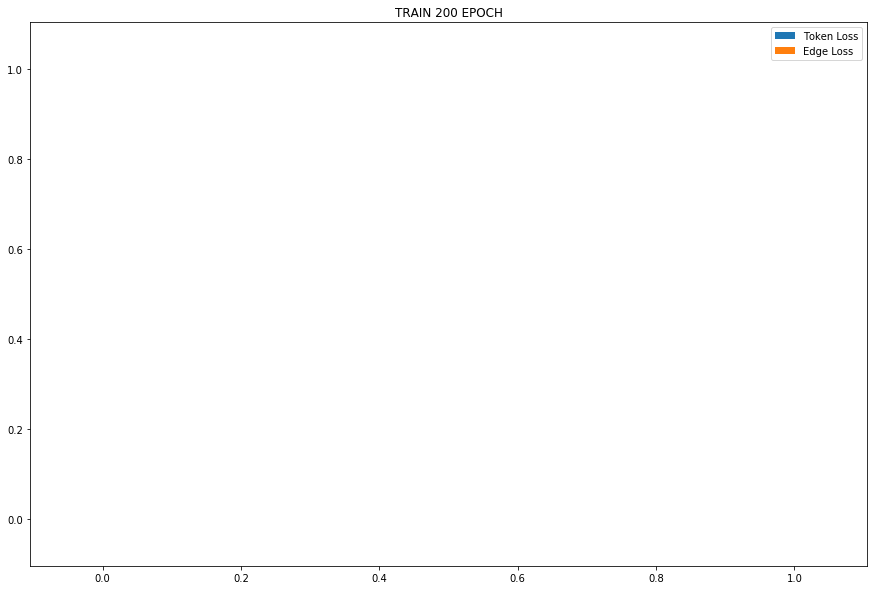

In [14]:
plt.stackplot([i for i in range(EPOCHS)], token_losses, edge_losses, labels=['Token Loss', 'Edge Loss'])
plt.title("TRAIN 200 EPOCH")
plt.legend()
plt.show()

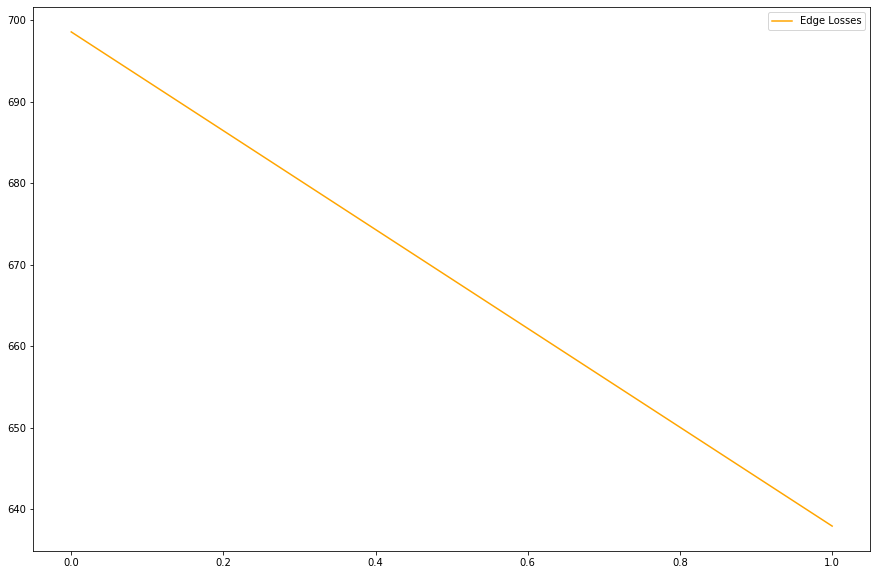

In [15]:
plt.plot(edge_losses, label="Edge Losses", color="orange")
plt.legend()
plt.show()

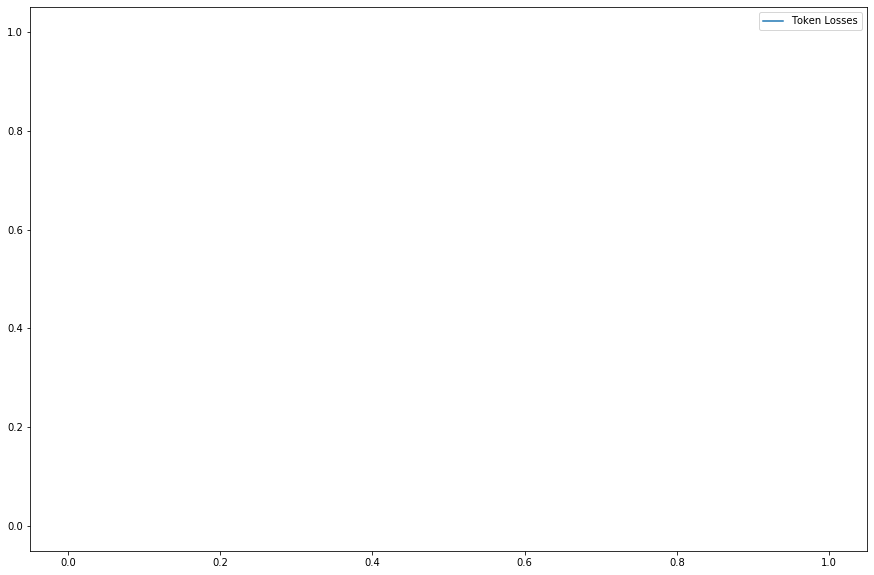

In [16]:
plt.plot(token_losses, label="Token Losses")
plt.legend()
plt.show()

## Inference

In [17]:
test_dataset = dataset_from_params(data_params, evaluation=True)

[2020-04-02 16:18:56,722 ERROR] Model name 'data/bert-base-cased/bert-base-cased-vocab.txt' was not found in model name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese). We assumed 'data/bert-base-cased/bert-base-cased-vocab.txt' was a path or url but couldn't find any file associated to this path or url.
0it [00:00, ?it/s][2020-04-02 16:18:56,728 INFO] Reading instances from lines in file at: ../data/raw/amr.txt.features
[2020-04-02 16:18:56,797 INFO] POS tag coverage: 0.3087 (184/596)
40it [00:00, 568.48it/s]
[2020-04-02 16:18:56,798 ERROR] Model name 'data/bert-base-cased/bert-base-cased-vocab.txt' was not found in model name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese). We assumed 'data/bert-base-cased/bert-base-cased-vocab.txt' was a path or url but couldn'

Building train datasets ...
True
Building dev datasets ...
True
Building test datasets ...
True


[2020-04-02 16:18:56,955 INFO] POS tag coverage: 0.3087 (184/596)
40it [00:00, 529.25it/s]


In [18]:
test_data = test_dataset['test']
test_data = Batch(test_data)
test_data.index_instances(vocab)
test_data_tensor = test_data.as_tensor_dict()

In [19]:
encoder_input, decoder_input, generator_input, parser_input = text_to_amr.prepare_input(test_data_tensor)

ENCODER_INPUT
bert_token: None
token_subword_index: None
token: (40, 25)
pos_tag: (40, 25)
must_copy_tag: (40, 25)
char: (40, 25, 14)
mask: (40, 25)

DECODER_INPUT
token: (40, 28)
pos_tag: (40, 28)
char: (40, 28, 17)
coref: (40, 28)

GENERATOR_INPUT
vocab_targets: (40, 28)
coref_targets: (40, 28)
coref_attention_maps: (40, 28, 29)
copy_targets: (40, 28)
copy_attention_maps: (40, 25, 27)

PARSER_INPUT
edge_heads: (40, 28)
edge_labels: (40, 28)
corefs: (40, 28)
mask: (40, 28)



In [20]:
test_model_input = create_model_input(encoder_input, decoder_input, generator_input, parser_input)
test_model_input += [test_data_tensor['src_copy_vocab'], test_data_tensor['tag_lut'], test_data_tensor.get('source_copy_invalid_ids', None)]

In [21]:
outputs = text_to_amr.predict(test_model_input)

  4%|▎         | 1/28 [00:05<02:37,  5.84s/it]


ValueError: too many values to unpack (expected 3)

In [ ]:
outputs['heads']

In [ ]:
outputs['heads'][0]

In [ ]:
for node in outputs['nodes']:
    print(node)